In [2]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.optimize as op
import scipy.stats as st
import numpy as np

sns.set_context("talk")

/usr/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def gauss(x, mean, std):
    A = 1/(std * np.sqrt(2 * np.pi))
    return A * np.exp(-0.5 * ((x - mean)/std)**2)

In [8]:
# Data From James Wang
cap_data = np.array([97.3, 95.3, 93.0, 92.1, 92.6, 93.8, 95.0, 95.0, 96.2,
                     94.1, 94.3, 93.9, 94.1, 94.7, 96.0, 97.1, 92.6, 93.0,
                     93.8, 94.5, 93.3, 95.8, 93.5, 96.2, 94.4, 93.5, 94.4,
                     95.6, 92.7, 95.3, 95.3, 94.9, 93.8, 96.3, 93.4, 94.5,
                     94.1, 92.0, 94.7, 94.1, 95.2, 93.7, 94.8, 94.2, 96.5,
                     94.2, 94.6, 93.0, 93.5, 88.7, 94.4, 92.3, 95.0, 92.9,
                     94.0, 93.3, 96.2, 94.2, 93.0, 94.8, 92.8, 93.2, 94.3,
                     93.4, 93.0, 94.1, 95.6, 93.8, 94.1, 95.2, 94.0, 94.7,
                     95.5, 96.4, 94.9, 94.9, 94.9, 94.6, 95.2, 94.0, 95.7,
                     93.3, 92.5, 96.2, 94.0, 94.8, 93.7, 95.3, 93.6, 93.2,
                     94.0, 93.7, 92.8, 92.6, 93.0, 94.9, 94.1, 93.5, 94.3,
                     96.1])

cap_data.sort()
cap_data = cap_data[:]

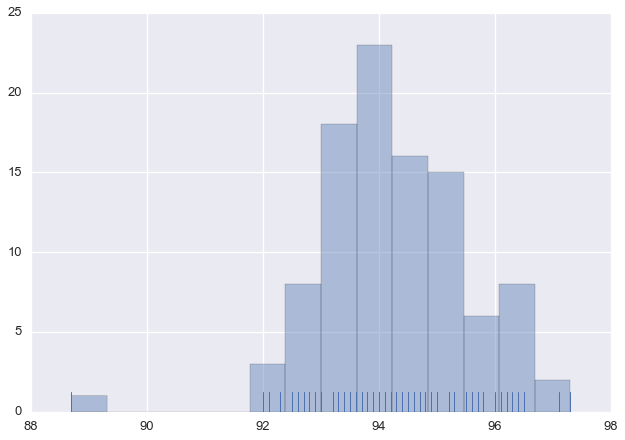

In [9]:
# One line to get eyes on the data.
# Then you can fiddle with the bin width and other decisions.
axis = sns.distplot(cap_data, kde=False, rug=True)

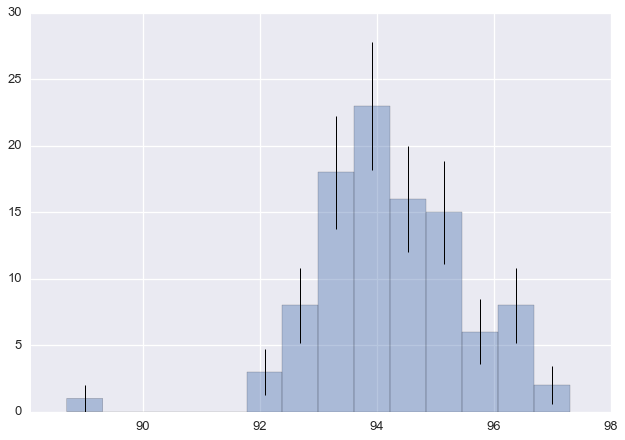

In [10]:
# Replot

cap_fig, cap_axis = plt.subplots()
cap_axis = sns.distplot(cap_data, kde=False, rug=False)

bar_width = cap_axis.patches[0].get_width()
bar_centers = np.array([bar.get_x() + bar_width/2 
                        for bar in cap_axis.patches if bar.get_height() != 0])

# Error bars
bar_heights = np.array([bar.get_height() 
                        for bar in cap_axis.patches if bar.get_height() != 0])

# How am I doing errors here? 
errors = np.sqrt(bar_heights)

for error_x, error_y, error in zip(bar_centers, bar_heights, errors):
    cap_axis.errorbar(error_x, error_y, error, color='black', elinewidth=1)

# Formatting
cap_axis.set_xlim(left=cap_data[0] - bar_width);

N:			 100
mean:			 94.25
standard deviation:	 1.41
error of the mean:	 0.13
min:			 88.7, -4.38 sigma
max:			 97.3,  2.41 sigma


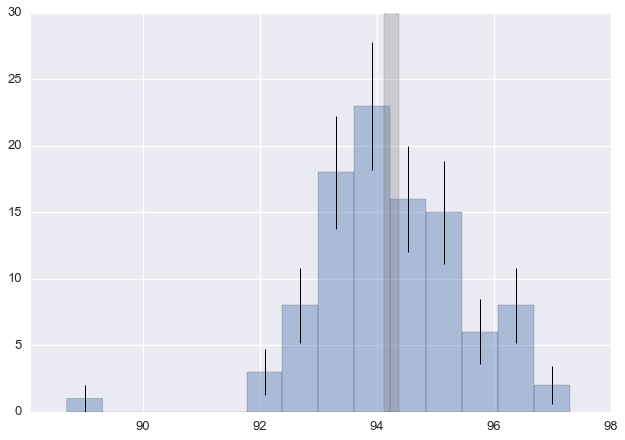

In [11]:
N = len(cap_data)
mean = cap_data.mean()
std = cap_data.std()
mean_error = std / np.sqrt(N)

cap_min = min(cap_data)
cap_min_std = (cap_min - mean) / std
cap_max = max(cap_data)
cap_max_std = (cap_max - mean) / std

xmin = cap_min - bar_width
xmax = cap_max + bar_width

x = np.linspace(cap_min - bar_width, cap_max + bar_width)

print 'N:\t\t\t {0}'.format(N)

print 'mean:\t\t\t {0:.2f}'.format(mean)

print 'standard deviation:\t {0:.2f}'.format(error)
# What does this mean again?

print 'error of the mean:\t {0:.2f}'.format(mean_error)

print 'min:\t\t\t {0:.1f}, {1:.2f} sigma'.format(cap_min, cap_min_std)

print 'max:\t\t\t {0:.1f},  {1:.2f} sigma'.format(cap_max, cap_max_std)

# Plot it
cap_axis.set_ylim(cap_axis.get_ylim())
cap_axis.set_xlim(cap_axis.get_xlim())
# shade the mean
shade = plt.Rectangle(xy=(mean - mean_error, 0),
                      width=(2 * mean_error),
                      height=40,
                      facecolor='grey',
                      alpha=0.3)

cap_axis.add_patch(shade)

cap_fig

Should I include the smallest point in the analysis?

What is it going to contribute to a chi squared analysis?

In fact, what are bins from 88-92 going to contribute to the analysis?

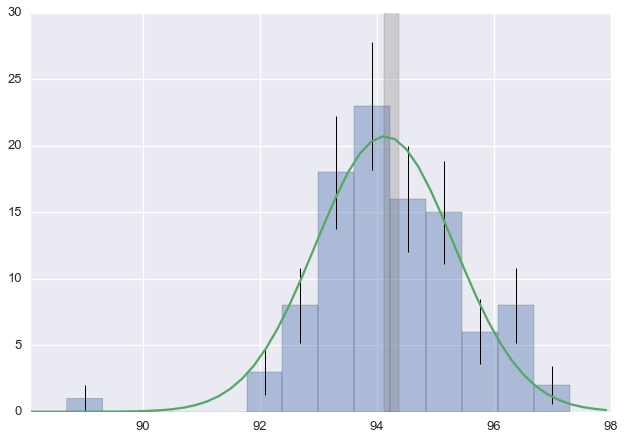

In [12]:
normed_heights = bar_heights / (N * bar_width)
(fit_mean, fit_err), covariance = op.curve_fit(gauss,
                                               bar_centers, normed_heights,
                                               p0=[mean, std])

cap_axis.plot(x, N * bar_width * gauss(x, mean=fit_mean, std=fit_err))
cap_fig

chi squared:	7.24089441883
reduced chi:	1.0344134884


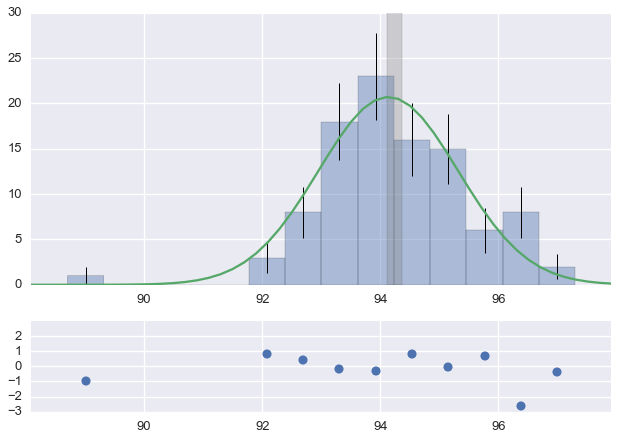

In [8]:
# How do we determine the degrees of freedom?
fitted_parameters = 2

fit_points = N * bar_width * gauss(bar_centers, fit_mean, fit_err)
diff = fit_points - bar_heights
std = np.sqrt(bar_heights)
chi2 = (diff / std)**2
residuals = np.sign(diff) * chi2

reduced_chi = sum(chi2)/(len(chi2)-fitted_parameters-1)
print 'chi squared:\t', sum(chi2)
print 'reduced chi:\t', reduced_chi

# add second plot to figure
grid = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[3,1])
cap_axis.set_position(grid[0].get_position(cap_fig))
residual_axis = cap_fig.add_subplot(grid[1], sharex=cap_axis)

residual_axis.plot(bar_centers, residuals, 'o');

# change number of y ticks and plot limits
yloc = plt.MaxNLocator(4)
residual_axis.yaxis.set_major_locator(yloc)
residual_axis.set_xlim(left=xmin, right=xmax)
residual_axis.set_ylim(-3, 3)
residual_axis.set_yticks(range(-3, 3, 1))


#grid.tight_layout(cap_fig)
cap_fig